## A first sampler

We would like to program a simple Metropolis sampler, it will contain the basic ingredients of any MCMC

In [1]:
import numpy as np
import scipy.integrate as integrate
def E(z,OmDE):
    """
    This function computes the integrand for the computation of the luminosity distance for a flat universe
    z -> float
    OmDE -> float
    gives
    E -> float
    """
    return 1/np.sqrt((1-OmDE)*(1+z)**3+OmDE)

def dl(z,OmDE,h=0.7):
    """
    This function computes the luminosity distance
    z -> float
    OmDE -> float
    h ->float
    returns
    dl -> float
    """
    inte=integrate.quad(E,0,z,args=(OmDE))
    # Velocidad del sonido en km/s
    c = 299792.458
    # Factor de Hubble
    Ho = 100*h
    return c*(1+z)/Ho * inte[0]
zandmu = np.loadtxt('../data/SCPUnion2.1_mu_vs_z.txt', skiprows=5,usecols=(1,2))
covariance = np.loadtxt('../data/SCPUnion2.1_covmat_sys.txt')
dl = np.vectorize(dl)
def loglike(params,h=0.7):
    """
    This function computes the logarithm of the likelihood. It recieves a vector
    params-> vector with one component (Omega Dark Energy)
    """
    OmDE = params[0]
# Ahora quiero calcular la diferencia entre el valor reportado y el calculado
    delta = 5.*np.log10(dl(zandmu[:,0],OmDE,h))+25-zandmu[:,1]
    chisquare=np.dot(delta,np.dot(np.linalg.inv(covariance),delta))
    return -chisquare/2


In [3]:
loglike([0.6])

-278.58971768190293

Now let's compute the Markov chain with the Metropolis algorithm:
Start from a certain point

In [21]:
start_point=[0.5]
chain=[start_point]
likelihood_chain=[loglike(start_point)]
step_width=[0.03]
number_of_steps=1000
accepted=0

In [22]:
for i in range(number_of_steps):
    #Generate a random number starting at the current point
    rand = np.random.normal(0.,1.,1)
    newpoint = chain[i] + step_width*rand
    #Compute the loglike in the new point
    liketry = loglike(newpoint)
    #Now the probability of acceptance
    if liketry > likelihood_chain[i]:
        prob_acceptance = 1
    else:
        prob_accept = np.exp(liketry - likelihood_chain[i])

    #Now compare that probability to a random number between 0 and 1
    if prob_accept >= np.random.uniform(0.,1.):
        chain.append(newpoint)
        likelihood_chain.append(liketry)
        accepted += 1
    else:
        chain.append(chain[i])
        likelihood_chain.append(likelihood_chain[i])

print "Razon de aceptacion =",float(accepted)/float(number_of_steps)

Razon de aceptacion = 0.363


We can use the previous result to obtain the average values of the sampled quantities

In [18]:
chain=np.array(chain)

In [19]:
omega_chain=chain[:,0]

In [11]:
average = np.mean(omega_chain)
print average

0.613828301834


We can even compute the asociated standard deviation

In [14]:
average_of_squares = np.mean(omega_chain**2)
sigma_omega = np.sqrt(average_of_squares-average**2)
print sigma_omega

0.0745711422263


Let's check the chain

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

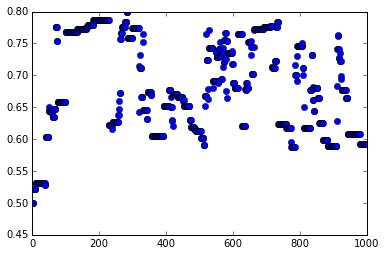

In [20]:
plt.plot(omega_chain,'o')

Try to do it for JLA data of for a w_DE=!0

## Make the chain into a function

In [53]:
def markovchain(steps, step_width, pasoinicial):
    chain=[pasoinicial]
    likechain=[loglike(chain[0])]
    accepted = 0
    for i in range(steps):
        rand = np.random.normal(0.,1.,len(pasoinicial))
        newpoint = chain[i] + step_width*rand
        liketry = loglike(newpoint)
        if np.isnan(liketry) :
            print 'Paso algo raro'
            liketry = -1E50
            accept_prob = 0
        elif liketry > likechain[i]:
            accept_prob = 1
        else:
            accept_prob = np.exp(liketry - likechain[i])

        if accept_prob >= np.random.uniform(0.,1.):
            chain.append(newpoint)
            likechain.append(liketry)
            accepted += 1
        else:
            chain.append(chain[i])
            likechain.append(likechain[i])
    chain = np.array(chain)
    likechain = np.array(likechain)

    print "Razon de aceptacion =",float(accepted)/float(steps)

    return chain, likechain

In [16]:
chain1, likechain1 = markovchain(100,0.06,[0.8])

Razon de aceptacion = 0.51


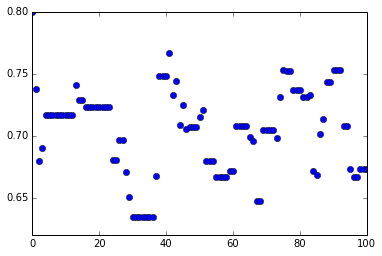

In [17]:
plt.plot(chain1,'o')

# Use the jla dataset

In [23]:
import pyfits
import glob
jla_dataset = np.genfromtxt('../data/jla/data/jla_lcparams.txt', names=True, dtype=None)
def mu_cov(alpha, beta):
    """ Assemble the full covariance matrix of distance modulus

    See Betoule et al. (2014), Eq. 11-13 for reference
    """
    Ceta = sum([pyfits.getdata(mat) for mat in glob.glob('../data/jla/covmat/C*.fits')])

    Cmu = np.zeros_like(Ceta[::3,::3])
    for i, coef1 in enumerate([1., alpha, -beta]):
        for j, coef2 in enumerate([1., alpha, -beta]):
            Cmu += (coef1 * coef2) * Ceta[i::3,j::3]

    # Add diagonal term from Eq. 13
    sigma = np.loadtxt('../data/jla/covmat/sigma_mu.txt')
    sigma_pecvel = (5 * 150 / 3e5) / (np.log(10.) * sigma[:, 2])
    Cmu[np.diag_indices_from(Cmu)] += sigma[:, 0] ** 2 + sigma[:, 1] ** 2 + sigma_pecvel ** 2
    
    return Cmu
def loglike(params,h=0.7):
    """
    This function computes the logarithm of the likelihood. It recieves a vector
    params-> vector with three components (Omega Dark Energy, alpha, beta and M_b)
    """
    OmDE = params[0]
    alpha = params[1]
    beta = params[2]
    MB = params[3]
    covariance = mu_cov(alpha, beta)
    inv_covariance=np.linalg.inv(covariance)
# Ahora quiero calcular la diferencia entre el valor reportado y el calculado
    mu_obs = jla_dataset['mb']-(MB-alpha*jla_dataset['x1']+beta*jla_dataset['color'])
    mu_teo = 5.*np.log10(dl(jla_dataset['zcmb'],OmDE,h))+25
    delta = mu_teo - mu_obs
    chisquare = np.dot(delta,np.dot(inv_covariance,delta))
    return -chisquare/2

In [24]:
param = [0.65,0.13,3.1,-20]
loglike(param)

-2343.1642968305632

In [25]:
chain1, likechain1 = markovchain(10,[0.06,0.1,0.1,0.1],[0.65,0.13,3.1,-20])

Razon de aceptacion = 0.3


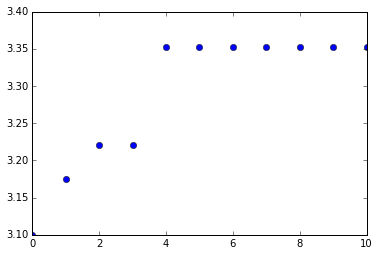

In [28]:
plt.plot(chain1[:,2],'o')

# Use a second parameter

In [57]:
import numpy as np
import scipy.integrate as integrate
def E(z,OmDE,w):
    """
    This function computes the integrand for the computation of the luminosity distance for a flat universe
    z -> float
    OmDE -> float
    gives
    E -> float
    """
    return 1/np.sqrt((1-OmDE)*(1+z)**3+OmDE*(1+z)**(3.*(1.+w)))

def dl(z,OmDE,w,h=0.7):
    """
    This function computes the luminosity distance
    z -> float
    OmDE -> float
    h ->float
    returns
    dl -> float
    """
    inte=integrate.quad(E,0,z,args=(OmDE,w))
    # Velocidad del sonido en km/s
    c = 299792.458
    # Factor de Hubble
    Ho = 100*h
    return c*(1+z)/Ho * inte[0]
zandmu = np.loadtxt('../data/SCPUnion2.1_mu_vs_z.txt', skiprows=5,usecols=(1,2))
covariance = np.loadtxt('../data/SCPUnion2.1_covmat_sys.txt')
dl = np.vectorize(dl)
def loglike(params,h=0.7):
    """
    This function computes the logarithm of the likelihood. It recieves a vector
    params-> vector with one component (Omega Dark Energy,dark energy equation of state)
    """
    OmDE = params[0]
    w = params[1]
# Ahora quiero calcular la diferencia entre el valor reportado y el calculado
    delta = 5.*np.log10(dl(zandmu[:,0],OmDE,w,h))+25-zandmu[:,1]
    chisquare=np.dot(delta,np.dot(np.linalg.inv(covariance),delta))
    return -chisquare/2




In [66]:
chain1, likechain1 = markovchain(100,[0.06,0.05],[0.7,-1.])

Razon de aceptacion = 0.49


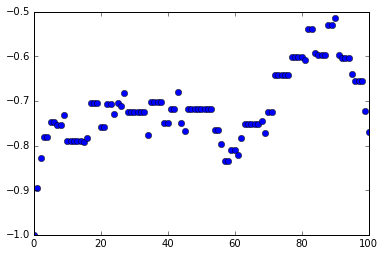

In [67]:
plt.plot(chain1[:,1],'o')

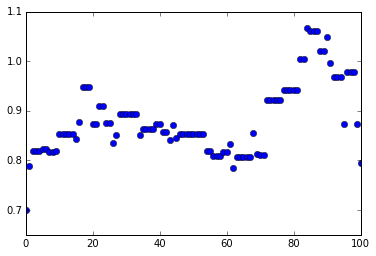

In [68]:
plt.plot(chain1[:,0],'o')